In [198]:
import torch
import numpy as np
import pandas as pd
from torch import Tensor

from typing import (
    Dict,
    List,
    Tuple,
    Set,
    Any,
    Annotated,
    Callable,
    Union,
    Type,
    Optional,
)

data = pd.read_csv('dataset_6.csv')

In [199]:
print(data.describe())
print(data.isnull().sum())

           feature_1      feature_2      feature_3         target
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        5.006825       5.003051       4.998433      28.613197
std         2.888864       2.889897       2.884420      20.031461
min         0.000081       0.000341       0.000256      -0.488483
25%         2.508727       2.495508       2.507904      11.460930
50%         5.007289       5.013033       4.976677      25.685016
75%         7.512871       7.505080       7.496536      42.450870
max         9.999931       9.999995       9.999936     105.931095
feature_1    0
feature_2    0
feature_3    0
target       0
dtype: int64


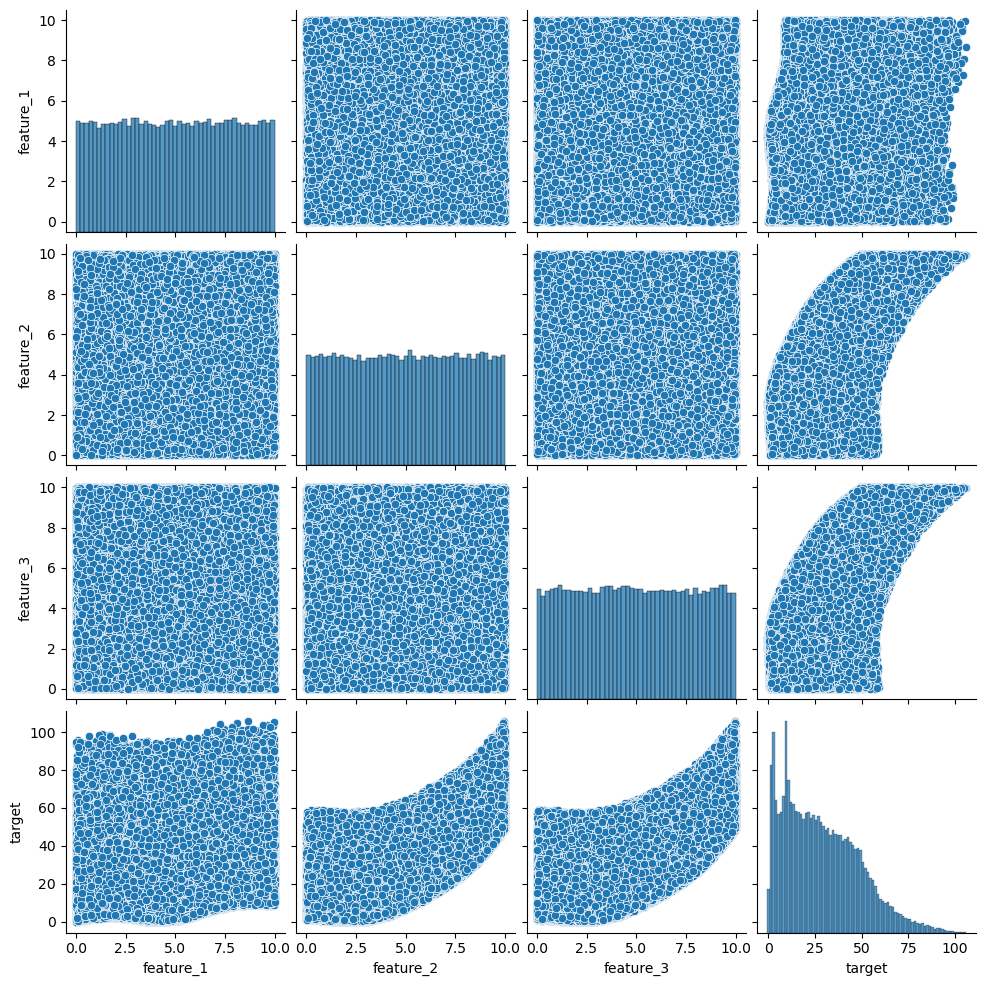

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(data[['feature_1', 'feature_2', 'feature_3', 'target']])

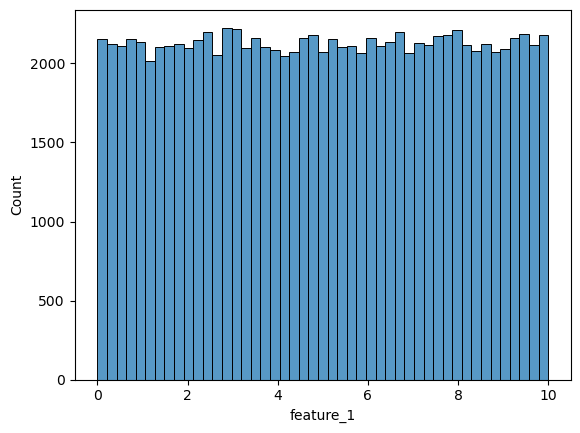

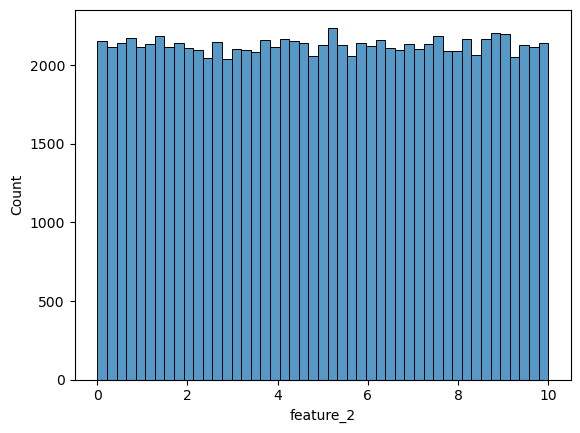

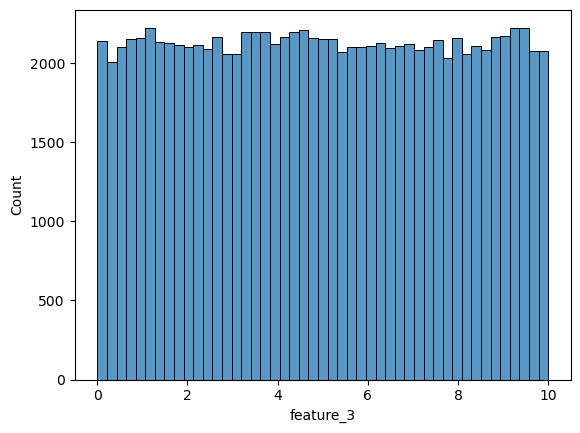

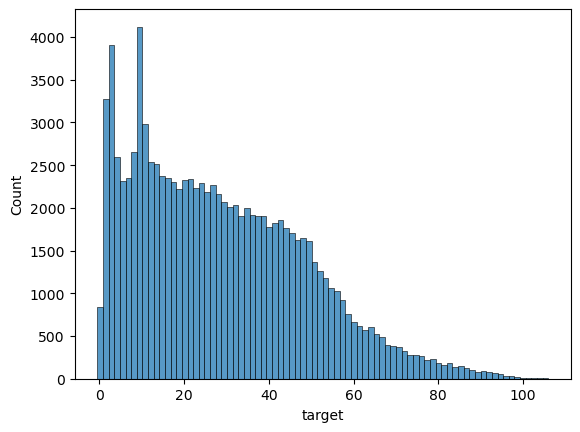

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data['feature_1'])
plt.show()

sns.histplot(data['feature_2'])
plt.show()

sns.histplot(data['feature_3'])
plt.show()

sns.histplot(data['target'])
plt.show()


In [202]:
x = torch.tensor(data.iloc[:, :-1].values, dtype=torch.float32)
y = torch.tensor(data.iloc[:, -1].values, dtype=torch.float32)

x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()

In [203]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset

def create_tensor_dataset(
    x: Tensor, y: Tensor, batch_size: int = 1000, shuffle: bool = True, sampler: Optional[Any] = None
) -> DataLoader:
    dataset = TensorDataset(x, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler)

def split_data(
    x: Tensor, y: Tensor, test_size: float = 0.2, val_size: float = 0.1, calib_size: float = 0.1
) -> Tuple[DataLoader, DataLoader, DataLoader, DataLoader]:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=42)
    x_train, x_calib, y_train, y_calib = train_test_split(x_train, y_train, test_size=calib_size, random_state=42)
    train_loader = create_tensor_dataset(x_train, y_train)
    test_loader = create_tensor_dataset(x_test, y_test)
    val_loader = create_tensor_dataset(x_val, y_val)
    calib_loader = create_tensor_dataset(x_calib, y_calib)
    return train_loader, test_loader, val_loader, calib_loader

train_loader, test_loader, val_loader, calib_loader = split_data(
    x, 
    y, 
    test_size=0.2, 
    val_size=0.1, 
    calib_size=0.1
)

In [204]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))
print(len(val_loader.dataset))
print(len(calib_loader.dataset))

64800
20000
8000
7200


In [205]:
class NN(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size, activation, layers_num):
        super(NN, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(input_size, hidden_size[0]))
        self.layers.append(activation())
        for i in range(1, layers_num):
            self.layers.append(torch.nn.Linear(hidden_size[i - 1], hidden_size[i]))
            self.layers.append(activation())
            
        self.layers.append(torch.nn.Linear(hidden_size[layers_num - 1], output_size))
        self.model = torch.nn.Sequential(*self.layers)
        
    def forward(self, x):
        x = torch.flatten(x, start_dim = 1)
        logits = self.model(x)
        return logits

In [206]:


def train(model, train_loader, lossFun):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
    epochs_num = 100
    model = model.train()
    
    for epoch in range(epochs_num):
        totalLoss = 0
        for x_batch, y_batch in train_loader:
            pred = model(x_batch)
            if torch.isnan(pred).any():
                break
            loss = lossFun(pred, y_batch.unsqueeze(1))
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            totalLoss += loss.item()
        
        averageLoss = totalLoss / len(train_loader)
        if (epoch + 1) % 5 == 0:
            print(f'Epoch - {epoch + 1}, Loss: {averageLoss:4f}')

In [207]:
def checkModel(model, loader, lossFun):
    model.eval()
    valLoss = 0
    with torch.no_grad():
        for x_batch, y_batch in loader:
            y_pred = model(x_batch)
            valLoss += lossFun(y_pred, y_batch.unsqueeze(1)).item()
            
    valLoss /= len(loader)
    return valLoss

In [208]:
def objective(params):
    hiddenLayerSize, activation, layers_num = params
    model = NN(
                input_size= x.shape[1], 
                output_size= 1, 
                hidden_size= hiddenLayerSize, 
                layers_num= layers_num,
                activation=activation)
    lossFun = torch.nn.MSELoss()
    
    train(model, train_loader, lossFun)
    print('value - ', checkModel(model, val_loader, lossFun))
    
    return checkModel(model, test_loader, lossFun)

In [209]:
class SinActivation(torch.nn.Module):
    def forward(self, x):
        return torch.sin(x)

In [210]:
hidden_layer_sizes = [[16, 32, 64, 128, 256, 128], 
                      [256, 128, 64, 32, 64, 16]]
activations = [torch.nn.ReLU, torch.nn.Tanh, SinActivation]
layers_nums = [2, 5, 6]

best_params = None
best_loss = float('inf')
results = []

for hidden_size in hidden_layer_sizes:
    for activation in activations:
        print(activation.__name__)
        for layers_num in layers_nums:
            params = (hidden_size, activation, layers_num)
            test_loss = objective(params)
            results.append({
                'hidden_layer_size': hidden_size,
                'activation': activation.__name__,
                'layers_num': layers_num,
                'test_loss': test_loss
            })
            if test_loss < best_loss:
                best_loss = test_loss
                best_params = params


ReLU
Epoch - 5, Loss: 1.058373
Epoch - 10, Loss: 1.028637
Epoch - 15, Loss: 1.003276
Epoch - 20, Loss: 0.980803
Epoch - 25, Loss: 0.959553
Epoch - 30, Loss: 0.939181
Epoch - 35, Loss: 0.918772
Epoch - 40, Loss: 0.897459
Epoch - 45, Loss: 0.875411
Epoch - 50, Loss: 0.852094
Epoch - 55, Loss: 0.827719
Epoch - 60, Loss: 0.801000
Epoch - 65, Loss: 0.772886
Epoch - 70, Loss: 0.742465
Epoch - 75, Loss: 0.709759
Epoch - 80, Loss: 0.675519
Epoch - 85, Loss: 0.638533
Epoch - 90, Loss: 0.599950
Epoch - 95, Loss: 0.559769
Epoch - 100, Loss: 0.518545
value -  0.5109081864356995
Epoch - 5, Loss: 1.003516
Epoch - 10, Loss: 1.001032
Epoch - 15, Loss: 0.998123
Epoch - 20, Loss: 0.995905
Epoch - 25, Loss: 0.993194
Epoch - 30, Loss: 0.990948
Epoch - 35, Loss: 0.988636
Epoch - 40, Loss: 0.986271
Epoch - 45, Loss: 0.983880
Epoch - 50, Loss: 0.981526
Epoch - 55, Loss: 0.978619
Epoch - 60, Loss: 0.976109
Epoch - 65, Loss: 0.972929
Epoch - 70, Loss: 0.969572
Epoch - 75, Loss: 0.965987
Epoch - 80, Loss: 0.961

In [215]:
df_results = pd.DataFrame(results)
print(df_results.sort_values(by = 'test_loss'))

              hidden_layer_size     activation  layers_num  test_loss
9    [256, 128, 64, 32, 64, 16]           ReLU           2   0.058171
6   [16, 32, 64, 128, 256, 128]  SinActivation           2   0.126732
16   [256, 128, 64, 32, 64, 16]  SinActivation           5   0.130525
15   [256, 128, 64, 32, 64, 16]  SinActivation           2   0.136536
12   [256, 128, 64, 32, 64, 16]           Tanh           2   0.144607
13   [256, 128, 64, 32, 64, 16]           Tanh           5   0.144622
17   [256, 128, 64, 32, 64, 16]  SinActivation           6   0.154045
3   [16, 32, 64, 128, 256, 128]           Tanh           2   0.158297
7   [16, 32, 64, 128, 256, 128]  SinActivation           5   0.159770
8   [16, 32, 64, 128, 256, 128]  SinActivation           6   0.161948
4   [16, 32, 64, 128, 256, 128]           Tanh           5   0.169025
14   [256, 128, 64, 32, 64, 16]           Tanh           6   0.178973
5   [16, 32, 64, 128, 256, 128]           Tanh           6   0.195810
0   [16, 32, 64, 128